### Customer Segmentation

In this notebook we are going to use unsupervised machine learning to clusture customers based on their shoping behaviour, given a set of variables.

### Imports

First we are going to start by importing all the packages that we are going to use in this notebook in the following code cell.


In [120]:
import os
import json
import warnings
import random

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import mutual_info_score, adjusted_rand_score
from sklearn.decomposition import PCA


warnings.filterwarnings("ignore")

print("Numpy: ", np.__version__)
print("Pandas: ", pd.__version__)
print("Seaborn: ", sns.__version__)

Numpy:  1.26.4
Pandas:  2.1.4
Seaborn:  0.12.2


### Seed 

Next we are going to set the seed for reproducivity in this notebook.

In [5]:
SEED = 23

random.seed(SEED)
np.random.seed(SEED)

### Constants

In the following code cell we are going to define some constants that will be used in this notebook.

In [7]:
COLORS = ['#638C6D', '#E7FBB4', '#DF6D2D', '#4C585B', '#474E93', '#D8C4B6', '#118B50']

### Data
In the following code cell we are going to load our data into a pandas dataframe. The dataset that we are using was obtained from kaggle at the following url:

https://www.kaggle.com/datasets/datascientistanna/customers-dataset/data


In [9]:
path = 'data/Customers.csv'
dataframe = pd.read_csv(path)
dataframe.head(3)

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1


The dataset that we are working with contains the following columns.

1. **Customer ID** - unique identifier of a customer.
2. **Gender** - The gender of the customer, either (Male or Female)
3. **Age** - The age of the customer
4. **Annual Income** - The anual income that customer earn.
5. **Spending Score** - Score assigned by the shop, based on customer behavior and spending nature
6. **Profession** - The profession of that particular customer.
7. **Work Experience** - Customer work experience in years.
8. **Family Size** - Number of his/her family members

### Exploratory Data Analysis (EDA)
    
Before we do any customer clustering we want to understand the customer data. Understanding data especially this customer data will helps us understanding the customer's shoping trends and make the business grow by making products that are tailor made for our customers based on their shoping behaviour.

In [11]:
dataframe.set_index('CustomerID', inplace=True)
dataframe.head(2)

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
CustomerID,,,,,,,
1,Male,19,15000,39,Healthcare,1,4
2,Male,21,35000,81,Engineer,3,3


Let's check the columns that we have in this dataframe.

In [13]:
dataframe.columns

Index(['Gender', 'Age', 'Annual Income ($)', 'Spending Score (1-100)',
       'Profession', 'Work Experience', 'Family Size'],
      dtype='object')

Next let's check the distribution of numerical features in the dataset interms of the:

1. `mean`
2. `std`
3. `count`
4. `median`
5. `min`
6. `max`
7. `quatiles(lower and upper)`

In [15]:
dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2000.0,48.9600,28.429747,0.0,25.0,48.0,73.00,99.0
Annual Income ($),2000.0,110731.8215,45739.536688,0.0,74572.0,110045.0,149092.75,189974.0
Spending Score (1-100),2000.0,50.9625,27.934661,0.0,28.0,50.0,75.00,100.0
Work Experience,2000.0,4.1025,3.922204,0.0,1.0,3.0,7.00,17.0
Family Size,2000.0,3.7685,1.970749,1.0,2.0,4.0,5.00,9.0


Let's check the info in the dataframe before we check for the null values that are in the dataframe.

In [17]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1 to 2000
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  2000 non-null   object
 1   Age                     2000 non-null   int64 
 2   Annual Income ($)       2000 non-null   int64 
 3   Spending Score (1-100)  2000 non-null   int64 
 4   Profession              1965 non-null   object
 5   Work Experience         2000 non-null   int64 
 6   Family Size             2000 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 125.0+ KB


Next let's check for the null values or now column values that are in the dataframe.

In [19]:
dataframe.isnull().sum()

Gender                     0
Age                        0
Annual Income ($)          0
Spending Score (1-100)     0
Profession                35
Work Experience            0
Family Size                0
dtype: int64

We can see that the are `35` null values in the `Profession` column. In the procession column we have the following values:

```py
['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist', 'Executive', 'Doctor', 'Homemaker', 'Marketing']
```
We want to change the profession value from `nan` in the profession column to be `Unknown`.

> ⌛ We are doing this to avoid losing `35` row of data by droping na values.

In [21]:
columns = np.array(['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist', 'Executive', 'Doctor', 'Homemaker', 'Marketing'])
dataframe.Profession = dataframe.Profession.apply(lambda x: "Unknown" if x not in columns else x)

In the followiung code cell let's check the distribution of gender in the dataset.

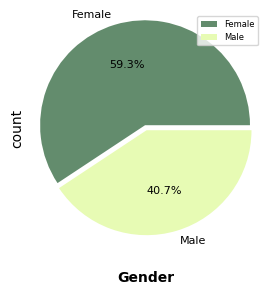

In [23]:
plt.figure(figsize=(3, 3))
counts = dataframe["Gender"].value_counts()
counts.plot(kind='pie', fontsize=8, explode=(0, .05), autopct='%1.1f%%', colors=COLORS)
plt.xlabel('Gender', weight="bold", fontsize=10, labelpad=20)
plt.axis('equal')
plt.legend(labels=counts.index, loc="best", fontsize=6)
plt.show()

We can see that the most customers in our dataset are females with a fraction of `59.3%` over `40.7%` of male. 


Let's check the work experience of customers.

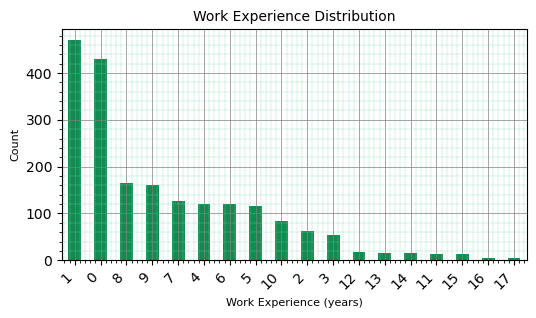

In [25]:
plt.figure(figsize=(6, 3))
dataframe['Work Experience'].value_counts().plot(kind='bar', color=COLORS[-1])
plt.title('Work Experience Distribution', fontsize=10)
plt.xlabel('Work Experience (years)', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(rotation=45, ha='right')

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

From the above didtribution, we can see that most of the customers have have `0` or `1` years of working experience.

Next let's check the distribution of our customers interms of `Profession`.

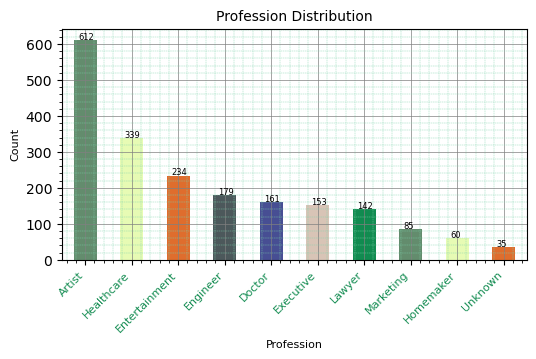

In [27]:

counts = dataframe.Profession.value_counts()

plt.figure(figsize=(6, 3))
bars = counts.plot(kind='bar', color=COLORS)

for bar, count in zip(bars.patches, counts):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 2, str(count), fontsize=6)

plt.title('Profession Distribution', fontsize=10)
plt.xlabel('Profession', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(rotation=45, ha='right', fontsize=8, color=COLORS[6])

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()


From the above distribution we can see that most of the customers are coming from the `Artist` and `Healthcare`.


Let's plot the distribution of `Gender` and `Profession` as a grouped bar chat.

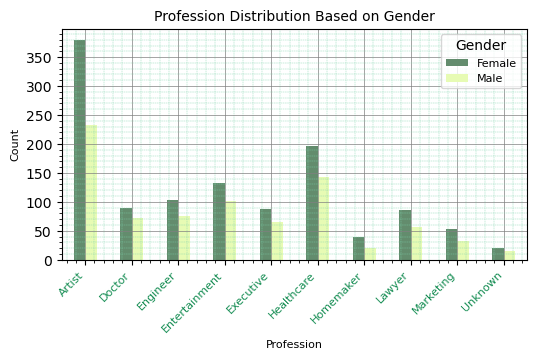

In [29]:
pivot_df = dataframe.pivot_table(index='Profession', columns='Gender', aggfunc='size', fill_value=0)

# Plot grouped bar chart
ax = pivot_df.plot(kind='bar', color=COLORS[:2], figsize=(6, 3))

ax.set_title('Profession Distribution Based on Gender', fontsize=10)
ax.set_xlabel('Profession', fontsize=8)
ax.set_ylabel('Count', fontsize=8)
ax.legend(title='Gender', fontsize=8)

plt.minorticks_on()
plt.xticks(rotation=45, ha='right', fontsize=8, color=COLORS[6])
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

Most of the customers are `Female` accros all proffessions.

In the next code cell we are going to check the distribution of `Age` using and `BoxPlot` so that we can see age distribution's quartiles and outliers.

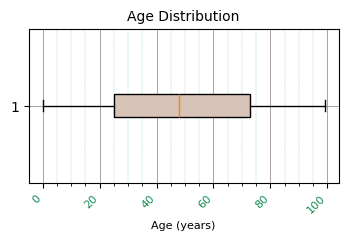

In [31]:

plt.figure(figsize=(4, 2))
plt.boxplot(dataframe.Age.values, vert=False, patch_artist=True, boxprops=dict(facecolor=COLORS[-2]))
plt.title("Age Distribution", fontsize=10)
plt.xlabel("Age (years)", fontsize=8)

plt.minorticks_on()
plt.xticks(rotation=45, ha='right', fontsize=8, color=COLORS[6])
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()


Most of the customers are between the age of `25` and `73`.

Next lets check the distribution of `Annual Income ($)` for our customers using the `Bar Plot` so that we can see outlier values of the `Annual Income ($)` in the dataset that we have.

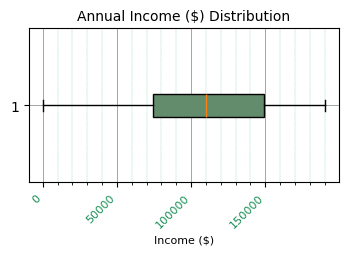

In [33]:

plt.figure(figsize=(4, 2))
plt.boxplot(dataframe['Annual Income ($)'].values, vert=False, patch_artist=True, boxprops=dict(facecolor=COLORS[-7]))
plt.title("Annual Income ($) Distribution", fontsize=10)
plt.xlabel("Income ($)", fontsize=8)

plt.minorticks_on()
plt.xticks(rotation=45, ha='right', fontsize=8, color=COLORS[6])
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

Let's check the distribution of the family sizes from our customers. For that we are going to use the bar chat to do that.

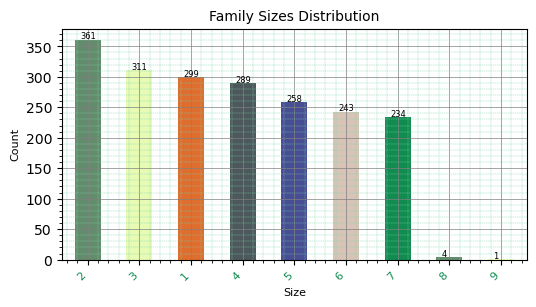

In [35]:
counts = dataframe['Family Size'].value_counts()

plt.figure(figsize=(6, 3))
bars = counts.plot(kind='bar', color=COLORS)

for bar, count in zip(bars.patches, counts):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 2, str(count), fontsize=6)

plt.title('Family Sizes Distribution', fontsize=10)
plt.xlabel('Size', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(rotation=45, ha='right', fontsize=8, color=COLORS[6])

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

Most of the customers that are in this dataset has a family size of `2`. We can assume that most the customers that might be couples. Only 1 customer have the family size that is of size `9`.

Next let's visualize the `Spending Score` of our customers using a box plot.

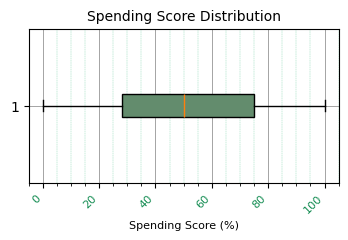

In [37]:
plt.figure(figsize=(4, 2))
plt.boxplot(dataframe['Spending Score (1-100)'].values, vert=False, patch_artist=True, boxprops=dict(facecolor=COLORS[-7]))
plt.title("Spending Score Distribution", fontsize=10)
plt.xlabel("Spending Score (%)", fontsize=8)

plt.minorticks_on()
plt.xticks(rotation=45, ha='right', fontsize=8, color=COLORS[6])
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

Now that we have analysed the data and understood the distribution of our data. Next we are going to start the process of feature so that we can implement customer segmentation/clustering using machine learning algorithmns. 

### Feature Processing

Some of our column values are text, we want to convert those column values to numbers and then we normalize them. The following transformations will be applied to each column.

1. **Gender** - `OrdinalEncoder` -> `StandardScaler()`
2. **Age** - `MixMaxScaler()`
3. **Annual Income** - `StandardScaler()`
4. **Spending Score** - `StandardScaler()`
5. **Profession** - `OrdinalEncoder` -> `StandardScaler()`
6. **Work Experience** - `MixMaxScaler()`
7. **Family Size** - `MixMaxScaler()`



In [39]:
ordinal_columns = ['Gender', 'Profession']
min_max_scaler_columns = ['Age', 'Work Experience', 'Family Size']
standard_scaler_columns = ['Spending Score (1-100)', 'Annual Income ($)']

std_scale_pipeline = Pipeline([
  ('standard_scaler', StandardScaler())
])
min_max_scale_pipeline = Pipeline([
  ('min_max_scaler', MinMaxScaler())
])
encode_and_scale_pipeline = Pipeline([
  ('odinal_scaler', OrdinalEncoder()),
  ('standard_scaler', StandardScaler())
])

ct = ColumnTransformer([
    ("std-columns", std_scale_pipeline,  standard_scaler_columns),
    ("ordinal-columns", encode_and_scale_pipeline, ordinal_columns),
    ("min-max-coloumns", min_max_scale_pipeline, min_max_scaler_columns),
])

features_transformed = ct.fit_transform(dataframe)
features_transformed.shape

(2000, 7)

In the next code cell we are going to check the first `2` features in the transformed features.

In [41]:
features_transformed[:2]

array([[-0.42833854, -2.09350095,  1.20706357,  0.77835593,  0.19191919,
         0.05882353,  0.375     ],
       [ 1.07554599, -1.65613312,  1.20706357, -0.35434734,  0.21212121,
         0.17647059,  0.25      ]])

Next we are going to set cluster our customers into 3 classes or groups. So we are going to make predictions based on the 3 clustering algorithmns which are:

1. `KMeans`
2. `AgglomerativeClustering`
3. `SpectralClustering`

In [72]:
N_CLUSTERS = 3

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=SEED, n_init=10)
ac = AgglomerativeClustering(n_clusters=N_CLUSTERS)
sc = SpectralClustering(n_clusters=N_CLUSTERS)
y_kmeans = kmeans.fit_predict(features_transformed)
y_ac = ac.fit_predict(features_transformed)
y_sc = sc.fit_predict(features_transformed)

Next we are going to check the first `6` classes that was predicted by each algorithm before we evaluate the algorithms.

In [74]:
print("K-Means Clusters: ", y_kmeans[:6])
print("Agglomerative Clustering Clusters: ", y_ac[:6])
print("Spectral Clustering Clusters: ", y_sc[:6])

K-Means Clusters:  [2 2 0 1 0 0]
Agglomerative Clustering Clusters:  [0 0 1 2 1 1]
Spectral Clustering Clusters:  [1 1 0 2 0 0]


### Algorithmns Evaluation

In the next following code cell we are going to evaluate our algorithmns based on the following metrics.

1. `Silhouette Score` - Is employed to assess a dataset's well-defined clusters. The value ranges for `-1` and `1`, a score close to `1` suggests well-separated clusters

2. `Davies-Bouldin Index` - It evaluates a dataset's clusters' compactness and separation. Lower numbers suggest better clustering solutions.
   
3. `Calinski-Harabasz Index (Variance Ratio Criterion)` - It is used to evaluate the quality of clusters within a dataset. Higher values indicate compact and well-separated clusters.


> Ref: https://www.geeksforgeeks.org/clustering-metrics/


In the following code cell we are going to create a function that will evaluate an algorithm and returns metrics per algorithmns.

In [76]:
def evaluate_algorithms(algorithm, X, y):
    silhouette = silhouette_score(X, y)
    db_index = davies_bouldin_score(X, y)
    ch_index = calinski_harabasz_score(X, y)
    return {
        "Silhouette Score": silhouette,
        "Davies-Bouldin Index": db_index,
        "Calinski-Harabasz Index": ch_index
    }

kmean_metrics = evaluate_algorithms(kmeans, features_transformed, y_kmeans)
sc_metrics = evaluate_algorithms(sc, features_transformed, y_sc)
ac_metrics = evaluate_algorithms(ac, features_transformed, y_ac)

Next we are going to check the metrics for each algorithm. First we are going to start with the `KMeans`

In [124]:
print(json.dumps(kmean_metrics, indent=2))

{
  "Silhouette Score": 0.22204129366218966,
  "Davies-Bouldin Index": 1.5963224108077405,
  "Calinski-Harabasz Index": 536.9265791124866
}


Then the `Spectral Clustering`

In [127]:
print(json.dumps(sc_metrics, indent=2))

{
  "Silhouette Score": 0.22134218390967836,
  "Davies-Bouldin Index": 1.6027070956855078,
  "Calinski-Harabasz Index": 534.1954553681874
}


Finally the `Agglomerative Clustering`.

In [130]:
print(json.dumps(ac_metrics, indent=2))

{
  "Silhouette Score": 0.19939623561024586,
  "Davies-Bouldin Index": 1.7481583628666382,
  "Calinski-Harabasz Index": 496.04342874343774
}


> ⌛ We can see that the `KMeans` is the better algorithms amoung all the algorithms that we used for clustering because it has better metrics than others.

Next we are going to visualize the metrics for our algorithmns using graphs.

In [78]:
keys = np.array(['K-Means', 'Agglomerative', 'Spectral'])
ss_scores = np.array([
    kmean_metrics['Silhouette Score'], 
    sc_metrics['Silhouette Score'], 
    ac_metrics['Silhouette Score']
])

bdi_scores = np.array([
    kmean_metrics['Davies-Bouldin Index'], 
    sc_metrics['Davies-Bouldin Index'], 
    ac_metrics['Davies-Bouldin Index']
])

chi_scores = np.array([
    kmean_metrics['Calinski-Harabasz Index'], 
    sc_metrics['Calinski-Harabasz Index'], 
    ac_metrics['Calinski-Harabasz Index']
])

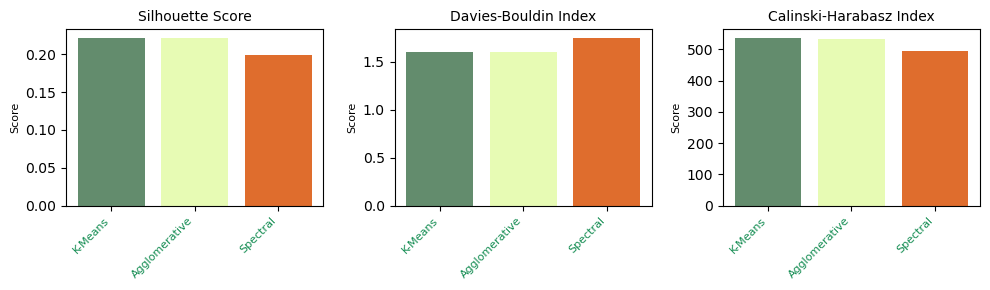

In [81]:

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].bar(keys, ss_scores, color=COLORS)
axes[0].set_title("Silhouette Score", fontsize=10)
axes[0].set_ylabel("Score", fontsize=8)
axes[0].set_xticklabels(keys, rotation=45, ha='right', fontsize=8, color=COLORS[-1])

axes[1].bar(keys, bdi_scores, color=COLORS)
axes[1].set_title("Davies-Bouldin Index", fontsize=10)
axes[1].set_ylabel("Score", fontsize=8)
axes[1].set_xticklabels(keys, rotation=45, ha='right', fontsize=8, color=COLORS[-1])

axes[2].bar(keys, chi_scores, color=COLORS)
axes[2].set_title("Calinski-Harabasz Index", fontsize=10)
axes[2].set_ylabel("Score", fontsize=8)
axes[2].set_xticklabels(keys, rotation=45, ha='right', fontsize=8, color=COLORS[-1])

plt.tight_layout()
plt.show()


### Visualizing clusters

In the code cells that follows we are going to visualize the clusters. We are going to start by a simple visualization of customer clusters which is visualizing the mean of each feature aganist each index.

In [91]:
n = 150
X = features_transformed
y = [i.mean() for i in X[:n]]
x = np.arange(n)
c = y_kmeans[:n]

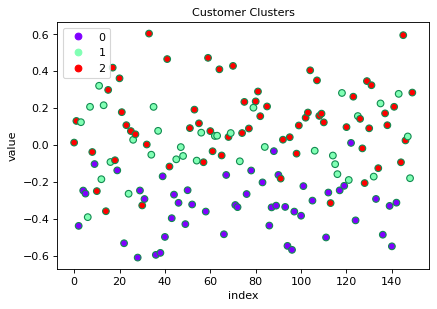

In [137]:
plt.figure(figsize=(6, 4), dpi=80)
scatter = plt.scatter(x, y, c=c, cmap='rainbow', edgecolor=COLORS[-1])
plt.title("Customer Clusters", color="k", fontsize=10)
plt.xlabel("index", fontsize=10)
plt.ylabel("value", fontsize=10)
plt.legend(handles=scatter.legend_elements()[0], labels=set(kmeans.labels_))
plt.show()

> 😒 The above method for dimensionality reduction is not that effective as we might lose important information about the relationships between the features and the clustering of the data.

So to solve this we will use `Principal of Component Analysis` to reduce the dimension of our features to be 2 and we plot those features aganist each other.

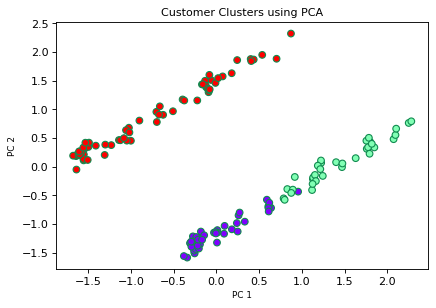

In [139]:
# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X[:n])

# Plot the clusters
plt.figure(figsize=(6, 4), dpi=80)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans[:n], cmap='rainbow', edgecolor=COLORS[-1])
plt.title("Customer Clusters using PCA", fontsize=10)
plt.xlabel("PC 1", fontsize=8)
plt.ylabel("PC 2", fontsize=8)
plt.show()

From the above we can see better clusters for the first `n` examples. Next we are going to visualize our Customer clusters in `3` D using the `scatter_3d`. Again we need to do dimentionality reduction to `3` using PCA.

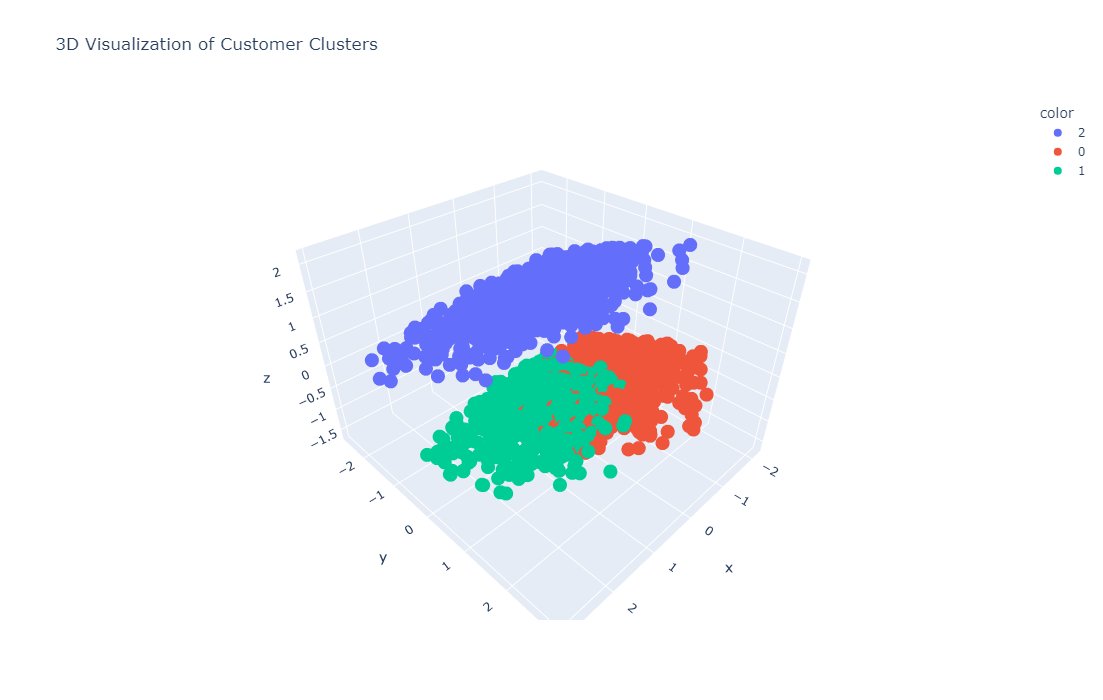

In [155]:
# Reduce to 3 dimensions for visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Interactive 3D plot
fig = px.scatter_3d(
    x=X_pca[:, 0], y=X_pca[:, 1], z=X_pca[:, 2], color=y_kmeans.astype(str),
    title="3D Visualization of Customer Clusters",
)
fig.update_layout(
    width=600,  # Set the width
    height=700  # Set the height
)
fig.show()

In the following code cell we are then going to visualize and explore relationships between features and visualize clusters. We are only going to take the first `n` samples.

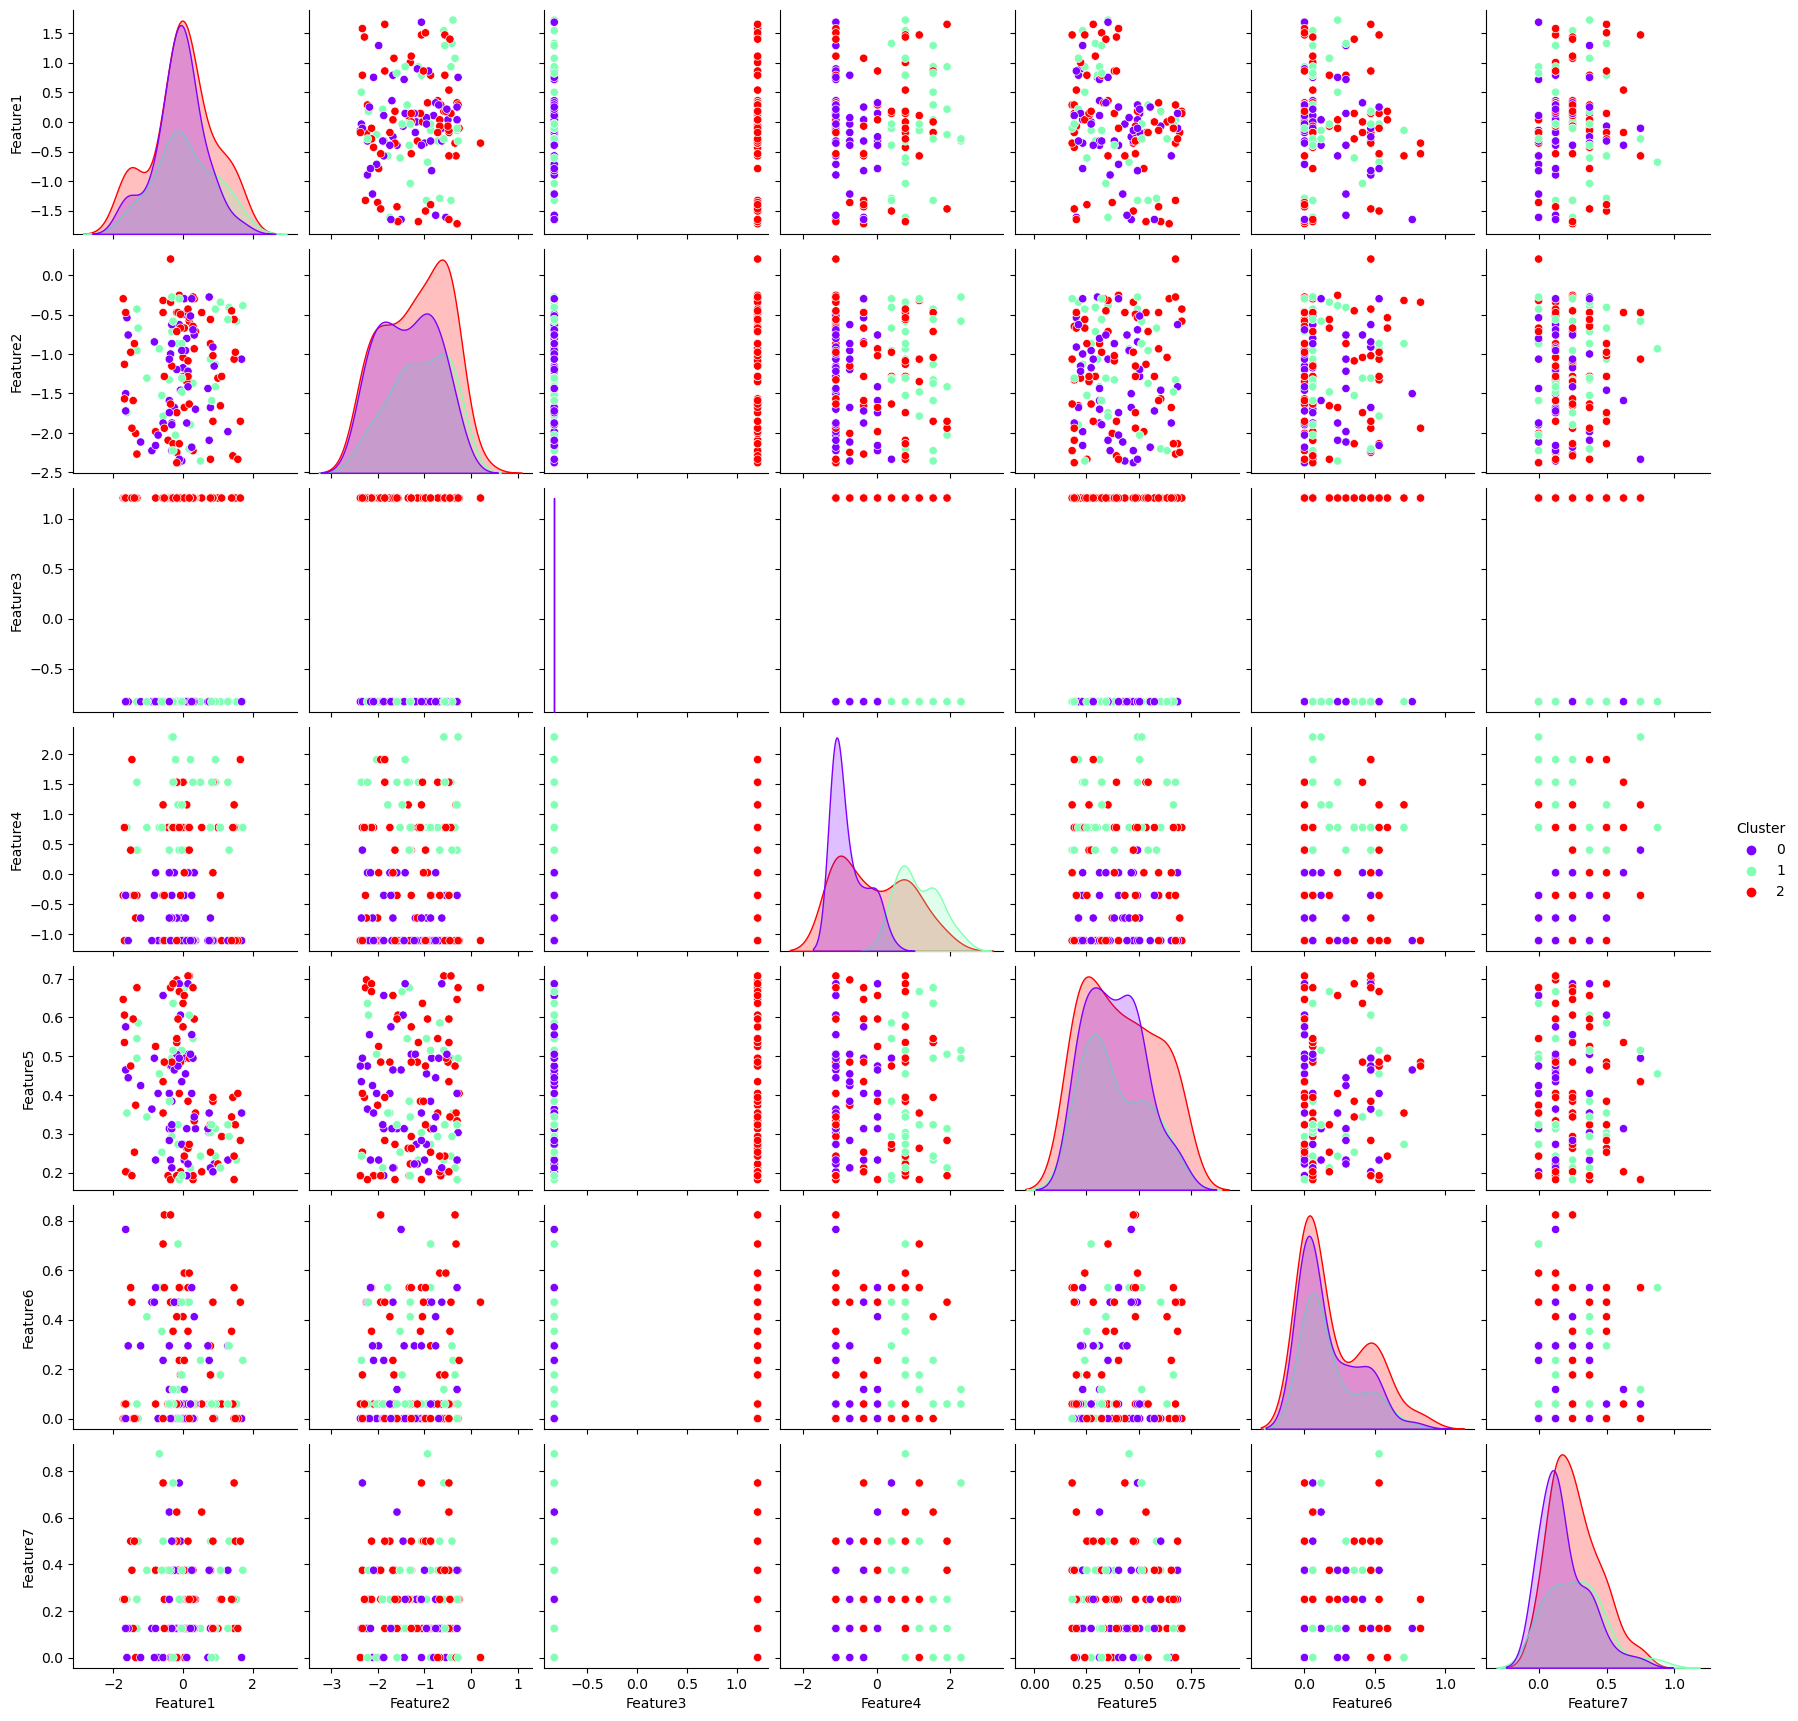

In [161]:
X = X[:n]
y_kmeans = y_kmeans[:n]

columns = [f'Feature{i+1}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=columns)
df['Cluster'] = y_kmeans
# Pairplot
sns.pairplot(df, hue='Cluster', palette='rainbow')
plt.show()